# Notebook 1 — Scraping IMDB Top 250 + KMeans (k=5) usando apenas a **sinopse**

Este notebook faz:
1. Web scraping dos **250 filmes** do IMDB Top 250 (título, ano, nota, votos, gêneros, duração, certificado, diretores, estrelas, sinopse).
2. Salva a base em `data/imdb_top250_raw.csv`.
3. Treina KMeans (k=5) **usando apenas a sinopse vetorizada (TF‑IDF)**.
4. Analisa clusters: top termos, tamanhos, amostras de títulos por cluster e métricas.
5. Exporta resultados em `data/imdb_top250_k5_synopsis.csv`.


In [1]:
import os, re, time, math, json, random, unicodedata
from pathlib import Path
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import numpy as np

# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Plots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Paths
DATA_DIR = Path('data'); DATA_DIR.mkdir(exist_ok=True)
BASE_URL = 'https://www.imdb.com'
TOP250_URL = 'https://www.imdb.com/chart/top/?ref_=nv_mv_250'
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9,pt-BR;q=0.8'
}


In [2]:
# ---------------------
# Utilitários de parsing
# ---------------------

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ''
    s = s.replace('\n', ' ').strip()
    s = re.sub(r'\s+', ' ', s)
    return s

def parse_year(text):
    if not text: return None
    m = re.search(r'(19|20)\d{2}', str(text))
    return int(m.group()) if m else None

def parse_runtime(text):
    # aceita formatos "2h 14m" ou "142 min"
    if not text: return None
    text = text.lower()
    h = 0; m = 0
    mh = re.search(r'(\d+)\s*h', text)
    mm = re.search(r'(\d+)\s*m', text)
    if mh: h = int(mh.group(1))
    if mm: m = int(mm.group(1))
    if 'min' in text and not mm:
        mm2 = re.search(r'(\d+)\s*min', text)
        if mm2: m = int(mm2.group(1))
    total = h*60 + m
    return total if total>0 else None

def parse_votes(text):
    if not text: return None
    text = text.replace(',', '').replace('.', '')
    m = re.search(r'(\d{3,})', text)
    return int(m.group(1)) if m else None

def sel_text(soup, selectors):
    for css in selectors:
        el = soup.select_one(css)
        if el and el.get_text(strip=True):
            return el.get_text(strip=True)
    return None

def sel_all_texts(soup, selectors):
    for css in selectors:
        els = soup.select(css)
        if els:
            out = [clean_text(e.get_text(strip=True)) for e in els if e.get_text(strip=True)]
            if out: return out
    return []


In [3]:
# ---------------------
# Scraping do Top 250
# ---------------------

def get_soup(url, sleep=0.0):
    if sleep: time.sleep(sleep)
    r = requests.get(url, headers=HEADERS, timeout=20)
    r.raise_for_status()
    return BeautifulSoup(r.text, 'html.parser')

def collect_top250_ids():
    # Coleta os primeiros 250 links únicos /title/ttXXXX/ na página do Top 250.
    soup = get_soup(TOP250_URL)
    hrefs = []
    for a in soup.select('a[href^="/title/tt"]'):
        href = a.get('href')
        if not href: continue
        m = re.match(r'^/title/(tt\d+)', href)
        if m:
            hrefs.append(m.group(1))
    # manter ordem e remover duplicatas
    seen, ids_ordered = set(), []
    for ttid in hrefs:
        if ttid not in seen:
            ids_ordered.append(ttid); seen.add(ttid)
        if len(ids_ordered) >= 250: break
    return ids_ordered

def scrape_title(ttid, delay_between_requests=0.5):
    url = f"{BASE_URL}/title/{ttid}/"
    soup = get_soup(url, sleep=delay_between_requests)

    # Título
    title = sel_text(soup, [
        'h1[data-testid="hero__pageTitle"] span',
        'h1[data-testid="hero-title-block__title"]',
        'h1'
    ])

    # Ano
    year_text = sel_text(soup, [
        'ul[data-testid="hero-title-block__metadata"] li:first-child a',
        'ul[data-testid="hero-title-block__metadata"] li:first-child span',
        'a[href*="releaseinfo"]',
    ])
    year = parse_year(year_text)

    # Nota
    rating_text = sel_text(soup, [
        'div[data-testid="hero-rating-bar__aggregate-rating__score"] span',
        'span[data-testid="hero-rating-bar__aggregate-rating__score"] span',
        'span[itemprop="ratingValue"]'
    ])
    try: rating = float(rating_text) if rating_text else None
    except: rating = None

    # Votos
    votes_text = sel_text(soup, [
        'div[data-testid="hero-rating-bar__aggregate-rating__score"] + div span',
        'div[data-testid="hero-rating-bar__aggregate-rating__score"] ~ div span',
        'a[href*="ratings?ref_"]'
    ])
    votes = parse_votes(votes_text)

    # Gêneros
    genres = sel_all_texts(soup, [
        'div[data-testid="genres"] a[href^="/search/title/?genres="]',
        'a[href^="/search/title/?genres="]'
    ])

    # Duração
    runtime_text = sel_text(soup, [
        'li[data-testid="title-techspec_runtime"] div ul li',
        'li[data-testid="title-techspec_runtime"]',
        'li[data-testid="title-details-releasedate"] ~ li'
    ])
    runtime_minutes = parse_runtime(runtime_text)

    # Certificado
    certificate = sel_text(soup, [
        'li[data-testid="title-details-certificate"] a',
        'a[href^="/search/title/?certificates="]'
    ])

    # Diretores
    directors = sel_all_texts(soup, [
        'li[data-testid="title-pc-principal-credit"] a[href^="/name/"]',
        'a[href^="/name/"]'
    ])
    directors = list(dict.fromkeys(directors))[:5]

    # Estrelas (aprox)
    stars = sel_all_texts(soup, [
        'div[data-testid="title-cast"] a[href^="/name/"]',
        'a[href^="/name/"]'
    ])
    stars = list(dict.fromkeys(stars))[:8]

    # Sinopse
    synopsis = sel_text(soup, [
        'span[data-testid="plot-xl"]',
        'span[data-testid="plot-l"]',
        'div[data-testid="plot"] span',
        'span[data-testid="plot"]'
    ]) or ""
    synopsis = clean_text(synopsis)

    return {
        'imdb_id': ttid,
        'url': url,
        'title': title,
        'year': year,
        'rating': rating,
        'votes': votes,
        'runtime_minutes': runtime_minutes,
        'certificate': certificate,
        'genres': '|'.join(genres) if genres else None,
        'directors': '|'.join(directors) if directors else None,
        'stars': '|'.join(stars) if stars else None,
        'synopsis': synopsis
    }


In [4]:
# Executa scraping completo (respeite o tempo de execução)
ids = collect_top250_ids()
print(f"IDs coletados: {len(ids)} filmes")

rows = []
for ttid in tqdm(ids, desc='Baixando páginas de títulos'):
    try:
        rows.append(scrape_title(ttid, delay_between_requests=0.4 + random.random()*0.3))
    except Exception as e:
        print(f"[WARN] Falhou {ttid}: {e}")

raw_df = pd.DataFrame(rows)
raw_path = Path('data') / 'imdb_top250_raw.csv'
raw_df.to_csv(raw_path, index=False, encoding='utf-8-sig')
print(f"Salvo: {raw_path.resolve()}")
raw_df.head()


IDs coletados: 25 filmes


Baixando páginas de títulos: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it]

Salvo: C:\Users\thi18\Downloads\projeto-imdb-recommender\notebooks\data\imdb_top250_raw.csv


,imdb_id,url,title,year,rating,votes,runtime_minutes,certificate,genres,directors,stars,synopsis
0,tt0111161,https://www.imdb.com/title/tt0111161/,The Shawshank Redemption,1994,9.3,None,142,None,None,Frank Darabont|Stephen King|Tim Robbins|Morgan...,Frank Darabont|Stephen King|Tim Robbins|Morgan...,A banker convicted of uxoricide forms a friend...
1,tt0068646,https://www.imdb.com/title/tt0068646/,The Godfather,1972,9.2,None,175,None,None,Francis Ford Coppola|Mario Puzo|Marlon Brando|...,Francis Ford Coppola|Mario Puzo|Marlon Brando|...,The aging patriarch of an organized crime dyna...
2,tt0468569,https://www.imdb.com/title/tt0468569/,The Dark Knight,2008,9.1,None,152,None,None,Christopher Nolan|Jonathan Nolan|David S. Goye...,Christopher Nolan|Jonathan Nolan|David S. Goye...,When a menace known as the Joker wreaks havoc ...
3,tt0071562,https://www.imdb.com/title/tt0071562/,The Godfather Part II,1974,9.0,None,202,None,None,Francis Ford Coppola|Mario Puzo|Al Pacino|Robe...,Francis Ford Coppola|Mario Puzo|Al Pacino|Robe...,The early life and career of Vito Corleone in ...
4,tt0050083,https://www.imdb.com/title/tt0050083/,12 Angry Men,1957,9.0,None,96,None,None,Sidney Lumet|Reginald Rose|Henry Fonda|Lee J. ...,Sidney Lumet|Reginald Rose|Henry Fonda|Lee J. ...,The jury in a New York City murder trial is fr...


## Limpeza mínima & inspeção


In [5]:
df = raw_df.copy()
df['synopsis'] = df['synopsis'].fillna('')
print(df.shape)
df.isna().sum()


(25, 12)


imdb_id             0
url                 0
title               0
year                0
rating              0
votes              25
runtime_minutes     0
certificate        25
genres             25
directors           0
stars               0
synopsis            0
dtype: int64

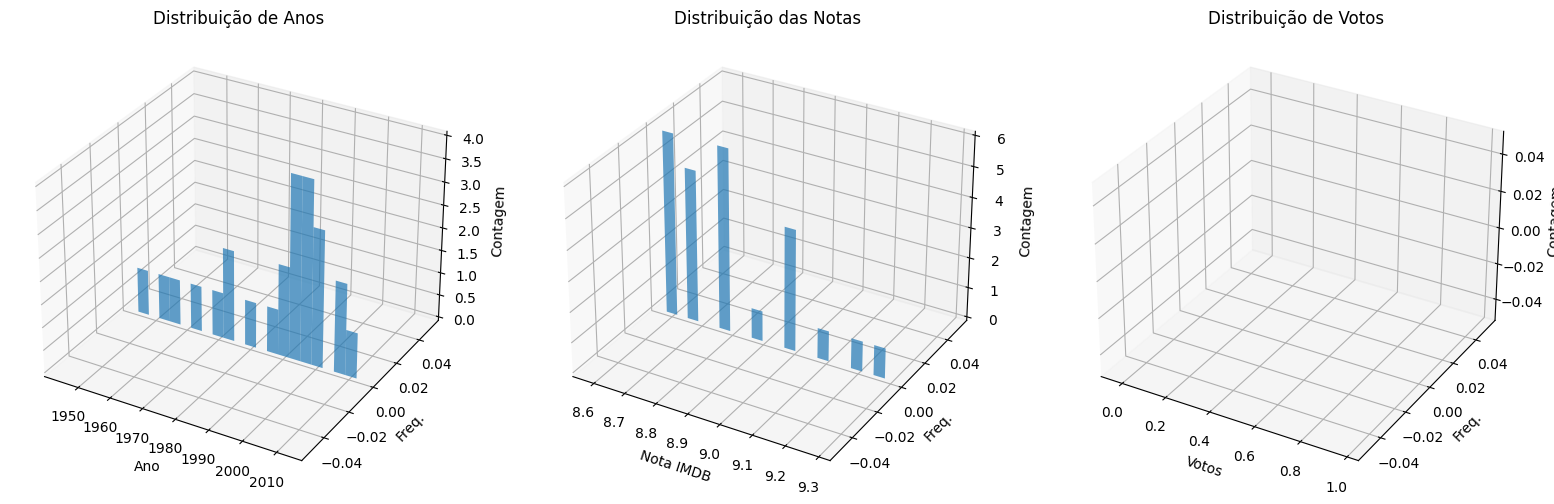

In [6]:
# Dados
year = df['year'].dropna()
rating = df['rating'].dropna()
votes = df['votes'].dropna()

fig = plt.figure(figsize=(16, 5))

# Gráfico 1 - Ano em 3D
ax1 = fig.add_subplot(131, projection='3d')
hist, bins = np.histogram(year, bins=20)
ax1.bar(bins[:-1], hist, zs=0, zdir='y', alpha=0.7, width=np.diff(bins))
ax1.set_xlabel('Ano')
ax1.set_ylabel('Freq.')
ax1.set_zlabel('Contagem')
ax1.set_title('Distribuição de Anos')

# Gráfico 2 - Nota IMDB em 3D
ax2 = fig.add_subplot(132, projection='3d')
hist, bins = np.histogram(rating, bins=20)
ax2.bar(bins[:-1], hist, zs=0, zdir='y', alpha=0.7, width=np.diff(bins))
ax2.set_xlabel('Nota IMDB')
ax2.set_ylabel('Freq.')
ax2.set_zlabel('Contagem')
ax2.set_title('Distribuição das Notas')

# Gráfico 3 - Votos em 3D
ax3 = fig.add_subplot(133, projection='3d')
hist, bins = np.histogram(votes, bins=20)
ax3.bar(bins[:-1], hist, zs=0, zdir='y', alpha=0.7, width=np.diff(bins))
ax3.set_xlabel('Votos')
ax3.set_ylabel('Freq.')
ax3.set_zlabel('Contagem')
ax3.set_title('Distribuição de Votos')

plt.tight_layout()
plt.show()


## Vetorização (TF‑IDF) e KMeans (k=5)


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=20000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.85
)
X = vectorizer.fit_transform(df['synopsis'])
print(X.shape)

k = 5
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
labels = kmeans.fit_predict(X)

df_out = df.copy()
df_out['cluster_k5_synopsis'] = labels

# Silhouette (amostra 200 para acelerar)
try:
    sample_idx = np.random.choice(X.shape[0], size=min(200, X.shape[0]), replace=False)
    sil = silhouette_score(X[sample_idx], labels[sample_idx])
except Exception:
    sil = float('nan')
print(f"Silhouette (amostrado): {sil:.4f}")

cluster_sizes = df_out['cluster_k5_synopsis'].value_counts().sort_index()
cluster_sizes


(25, 35)
Silhouette (amostrado): 0.1694


cluster_k5_synopsis
0    16
1     3
2     2
3     2
4     2
Name: count, dtype: int64

In [8]:
centers = kmeans.cluster_centers_
terms = np.array(vectorizer.get_feature_names_out())

TOPN = 15
for c in range(k):
    idx = centers[c].argsort()[::-1][:TOPN]
    print(f"\nCluster {c} — top termos:")
    print(', '.join(terms[idx]))



Cluster 0 — top termos:
convict, team, new, earth, world, sent, companions, frustrated, control, son, crime, city, new york, york, york city

Cluster 1 — top termos:
life, wife, mob, lives, bandits, bounty, city, companions, control, convict, killer, doom, earth, empire, frodo

Cluster 2 — top termos:
killer, serial killer, serial, help, veteran, doom, frustrated, frodo sam, frodo, empire, earth, york city, crime, convict, companions

Cluster 3 — top termos:
sam, frodo sam, frodo, sauron, help, new, ring, doom, men, world, city, companions, control, convict, crime

Cluster 4 — top termos:
alliance, bounty, men, empire, earth, help, frustrated, frodo sam, frodo, doom, life, crime, convict, control, companions


In [9]:
for c in range(k):
    print(f"\n=== Cluster {c} — {(df_out['cluster_k5_synopsis']==c).sum()} filmes ===")
    sample = df_out.loc[df_out['cluster_k5_synopsis']==c, ['title','year','rating']].head(8)
    print(sample.to_string(index=False))



=== Cluster 0 — 16 filmes ===
                                            title  year  rating
                         The Shawshank Redemption  1994     9.3
                                    The Godfather  1972     9.2
                                  The Dark Knight  2008     9.1
                            The Godfather Part II  1974     9.0
                                     12 Angry Men  1957     9.0
                                 Schindler's List  1993     9.0
The Lord of the Rings: The Fellowship of the Ring  2001     8.9
                                     Forrest Gump  1994     8.8

=== Cluster 1 — 3 filmes ===
       title  year  rating
Pulp Fiction  1994     8.8
  The Matrix  1999     8.7
  Goodfellas  1990     8.7

=== Cluster 2 — 2 filmes ===
                   title  year  rating
                   Se7en  1995     8.6
The Silence of the Lambs  1991     8.6

=== Cluster 3 — 2 filmes ===
                                        title  year  rating
The Lord of the Ri

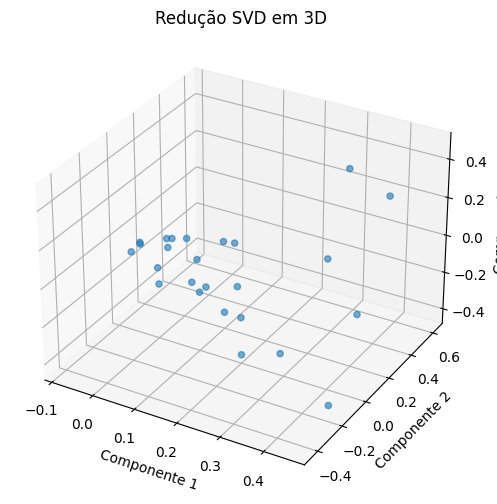

In [10]:
# 1) Vetorização dos textos
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_text = vectorizer.fit_transform(df['synopsis'].dropna())  # substitua 'synopsis' pela coluna de textos do seu dataset

# 2) Redução de dimensionalidade para 3D
svd1 = TruncatedSVD(n_components=3, random_state=42)
X1_red_3d = svd1.fit_transform(X_text)

# 3) Plotagem 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1_red_3d[:, 0], X1_red_3d[:, 1], X1_red_3d[:, 2], alpha=0.6)

ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Componente 3")
ax.set_title("Redução SVD em 3D")

plt.show()

In [11]:
syn_path = Path('data') / 'imdb_top250_k5_synopsis.csv'
df_out.to_csv(syn_path, index=False, encoding='utf-8-sig')
print(f"Salvo: {syn_path.resolve()}")


Salvo: C:\Users\thi18\Downloads\projeto-imdb-recommender\notebooks\data\imdb_top250_k5_synopsis.csv


### Comentários/Insights (preencher)
- Comente temas dos clusters pelos top termos e amostras.
- Avalie distribuição de notas/anos por cluster.
- Limitações: apenas sinopse, idioma, mudanças no HTML, etc.
